In [1]:
# Load all helper function
%run -i '../util/helper.py'

# Load Dataset and Data Split

In [2]:
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded_scaled.csv')
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [4]:
print(X_dev.shape)
print(X_test.shape)

(92506, 29)
(23127, 29)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [5]:
loss = ["hinge", "squared_hinge"]
C = [0, 0.5, 1]
penalty = ["l1", "l2"]
start3 = time()

parameter_grid = {'classifier__loss':loss,'classifier__penalty': penalty, 'classifier__C': C}

pipe_SVM_tune = Pipeline([('classifier',LinearSVC(max_iter=3000, dual=False, random_state=random_state))])

pipe_SVM = make_pipeline(GridSearchCV(pipe_SVM_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_SVM.fit(X_dev, np.ravel(y_dev))
end3 = time()
print("SVM model takes " + str(end3-start3) + "seconds")
print("The performance of the SVM model on test data is ", pipe_SVM.score(X_test, y_test))
grid_search_SVM = pipe_SVM.named_steps["gridsearchcv"]
print(f"The SVM model Best hyperparameters is ", grid_search_SVM.best_params_)

SVM model takes 31.981507062911987seconds
The performance of the SVM model on test data is  0.10660980810234541
The SVM model Best hyperparameters is  {'classifier__C': 0.5, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'l1'}


### Evaluate on the Test Set

In [6]:
SVM_prediction = pipe_SVM.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,SVM_prediction)}')
print(f'Recall: {recall_score(y_test,SVM_prediction)}')
print(f'Precision: {precision_score(y_test,SVM_prediction)}')
print(f'F-1 Score: {f1_score(y_test,SVM_prediction)}')

recall, precision = recall_score(y_test,SVM_prediction), precision_score(y_test,SVM_prediction)

Accuracy: 0.9275305919488044
Recall: 0.05737234652897304
Precision: 0.7518796992481203
F-1 Score: 0.10660980810234541


#### Calibration & Recall

Text(0.5, 1.0, 'Calibration')

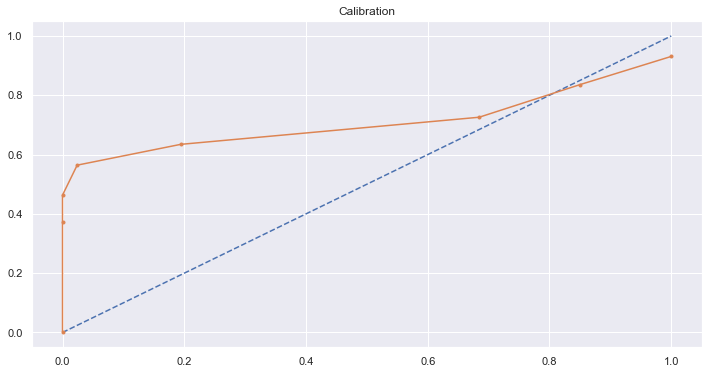

In [7]:
probs = pipe_SVM.decision_function(X_test)
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')
plt.title("Calibration")

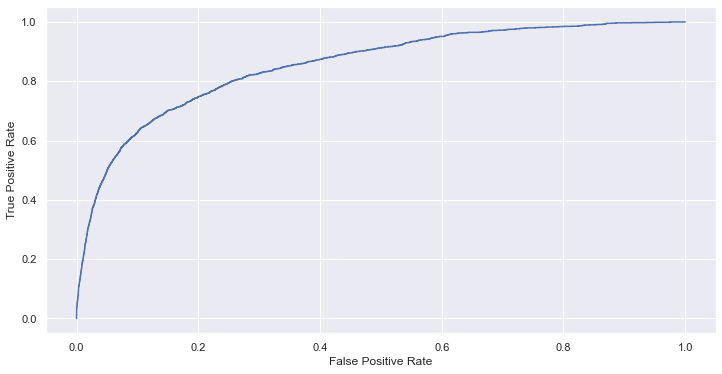

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

#### Feature  Importances

Text(0.5, 1.0, 'Feature Importance')

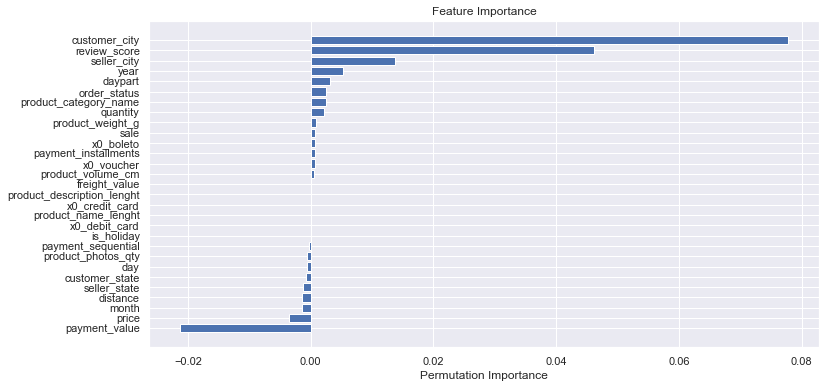

In [9]:
perm_importance = permutation_importance(pipe_SVM, X_test, y_test)

feature_names = X.columns
feat_imp = perm_importance.importances_mean
sorted_idx = feat_imp.argsort()
plt.barh(feature_names[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")

In [10]:
filename = '../model/SVM_stratified.sav'
pickle.dump(pipe_SVM, open(filename, 'wb'))

## Downsampling

In [11]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

### GridSearch

In [12]:
loss = ["hinge", "squared_hinge"]
C = [0, 0.5, 1]
penalty = ["l1", "l2"]
start3 = time()

parameter_grid = {'classifier__loss':loss,'classifier__penalty': penalty, 'classifier__C': C}

pipe_SVM_tune = Pipeline([('classifier',LinearSVC(max_iter=3000, dual=False, random_state=random_state))])

pipe_SVM = make_pipeline(GridSearchCV(pipe_SVM_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_SVM.fit(X_dev_us, np.ravel(y_dev_us))
end3 = time()
print("SVM model takes " + str(end3-start3) + "seconds")
print("The performance of the SVM model on test data is ", pipe_SVM.score(X_test, y_test))
grid_search_SVM = pipe_SVM.named_steps["gridsearchcv"]
print(f"The SVM model Best hyperparameters is ", grid_search_SVM.best_params_)

SVM model takes 1.7443301677703857seconds
The performance of the SVM model on test data is  0.3676323676323676
The SVM model Best hyperparameters is  {'classifier__C': 0.5, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'l2'}


### Evaluate on the Test Set

In [13]:
SVM_prediction = pipe_SVM.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,SVM_prediction)}')
print(f'Recall: {recall_score(y_test,SVM_prediction)}')
print(f'Precision: {precision_score(y_test,SVM_prediction)}')
print(f'F-1 Score: {f1_score(y_test,SVM_prediction)}')

recall, precision = recall_score(y_test,SVM_prediction), precision_score(y_test,SVM_prediction)

Accuracy: 0.8084057595018809
Recall: 0.7389558232931727
Precision: 0.24468085106382978
F-1 Score: 0.3676323676323676


#### Calibration and ROC Curve

Text(0.5, 1.0, 'Calibration')

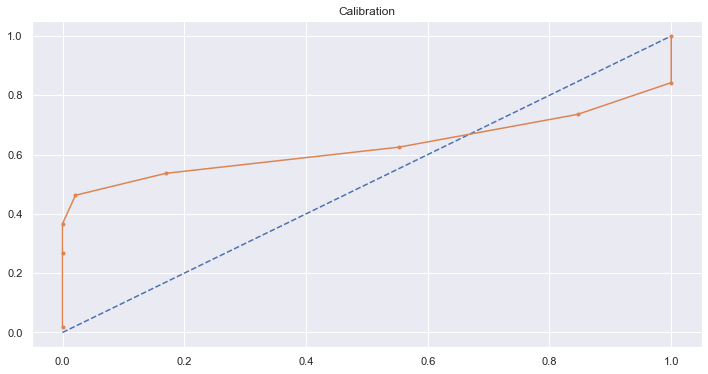

In [14]:
probs = pipe_SVM.decision_function(X_test)
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')
plt.title("Calibration")

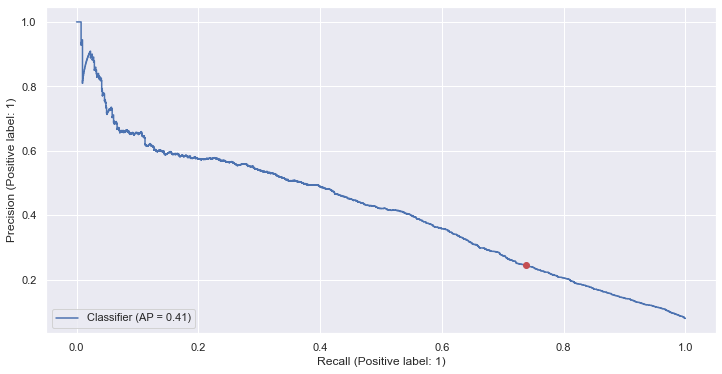

In [15]:
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

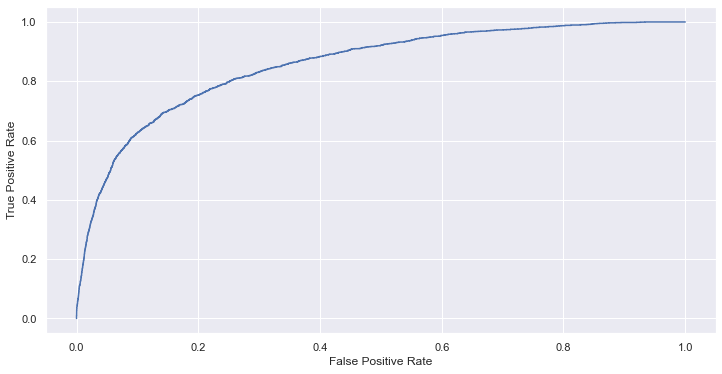

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

#### Feature  Importances


Text(0.5, 1.0, 'Feature Importance')

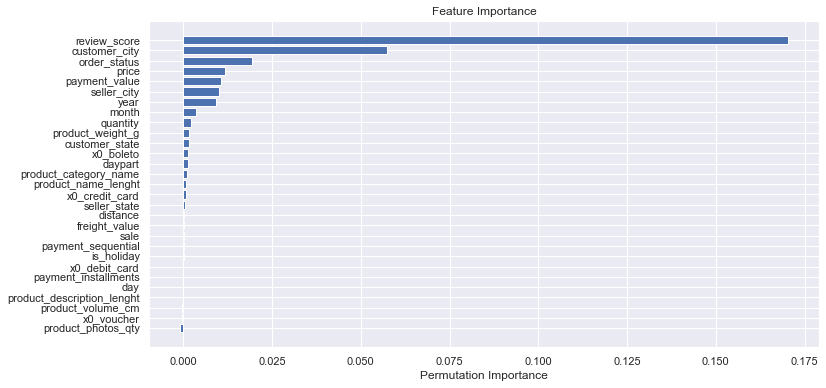

In [17]:
perm_importance = permutation_importance(pipe_SVM, X_test, y_test)

feature_names = X.columns
feat_imp = perm_importance.importances_mean
sorted_idx = feat_imp.argsort()
plt.barh(feature_names[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")

In [18]:
filename = '../Model/SVM_downsampling.sav'
pickle.dump(pipe_SVM, open(filename, 'wb'))